In [1]:
import os
from tensorflow import keras
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np
import tensorflow as tf
from keras.applications import ResNet50

In [2]:
# on Google Colab, get the dataset from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# unzip the dataset for use
from zipfile import ZipFile
file_name = '/content/drive/MyDrive/Poison Plant Classifier/Dataset.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [4]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import splitfolders

splitfolders.ratio("Dataset", # The location of dataset
                   output="Training_Datasets", # The output location
                   seed=42, # The number of seed
                   ratio=(.8, .2), # The ratio of splited dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )

Copying files: 10610 files [00:04, 2282.39 files/s]


In [6]:
train_dir = os.path.join('/content/Training_Datasets', 'train')
validation_dir = os.path.join('/content/Training_Datasets', 'val')

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            label_mode='int',
                                                            batch_size=64,
                                                            image_size=(224, 224))

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 label_mode='int',
                                                                 batch_size=64,
                                                                 image_size=(224, 224))

Found 8486 files belonging to 4 classes.
Found 2124 files belonging to 4 classes.


In [7]:
base_model = keras.Sequential()
base_model.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
base_model.add(Dropout(0.2))
base_model.add(Dense(4, activation='softmax'))

base_model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

94765736/94765736 [==============================] - 1s 0us/step


In [8]:
resnet_history = base_model.fit(train_dataset, validation_data = validation_dataset, epochs = 20)

Epoch 1/20
133/133 [==============================] - 115s 715ms/step - loss: 5.3325 - accuracy: 0.3500 - val_loss: 3.0429 - val_accuracy: 0.4435
Epoch 2/20
133/133 [==============================] - 94s 699ms/step - loss: 3.4347 - accuracy: 0.4694 - val_loss: 2.4192 - val_accuracy: 0.5315
Epoch 3/20
133/133 [==============================] - 94s 697ms/step - loss: 2.5523 - accuracy: 0.5262 - val_loss: 2.1041 - val_accuracy: 0.5678
Epoch 4/20
133/133 [==============================] - 93s 696ms/step - loss: 2.0377 - accuracy: 0.5539 - val_loss: 1.7860 - val_accuracy: 0.5913
Epoch 5/20
133/133 [==============================] - 94s 696ms/step - loss: 1.7405 - accuracy: 0.5793 - val_loss: 1.5452 - val_accuracy: 0.6073
Epoch 6/20
133/133 [==============================] - 94s 696ms/step - loss: 1.5312 - accuracy: 0.6042 - val_loss: 1.4871 - val_accuracy: 0.6106
Epoch 7/20
133/133 [==============================] - 95s 705ms/step - loss: 1.3923 - accuracy: 0.6342 - val_loss: 1.4558 - val_a

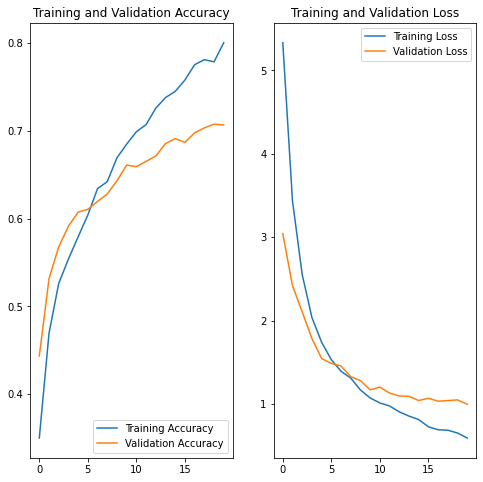

In [9]:
import matplotlib.pyplot as plt

acc = resnet_history.history['accuracy']
val_acc = resnet_history.history['val_accuracy']

loss = resnet_history.history['loss']
val_loss = resnet_history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
resnet_history = base_model.fit(train_dataset, validation_data = validation_dataset, epochs = 10)

Epoch 1/10
133/133 [==============================] - 95s 701ms/step - loss: 0.5843 - accuracy: 0.8057 - val_loss: 1.0028 - val_accuracy: 0.7076
Epoch 2/10
133/133 [==============================] - 94s 697ms/step - loss: 0.5531 - accuracy: 0.8126 - val_loss: 0.9921 - val_accuracy: 0.7128
Epoch 3/10
133/133 [==============================] - 94s 698ms/step - loss: 0.5113 - accuracy: 0.8258 - val_loss: 0.9788 - val_accuracy: 0.7123
Epoch 4/10
133/133 [==============================] - 94s 696ms/step - loss: 0.4924 - accuracy: 0.8295 - val_loss: 0.9643 - val_accuracy: 0.7189
Epoch 5/10
133/133 [==============================] - 94s 698ms/step - loss: 0.4580 - accuracy: 0.8417 - val_loss: 0.9625 - val_accuracy: 0.7194
Epoch 6/10
133/133 [==============================] - 94s 697ms/step - loss: 0.4495 - accuracy: 0.8422 - val_loss: 0.9800 - val_accuracy: 0.7156
Epoch 7/10
133/133 [==============================] - 94s 698ms/step - loss: 0.4347 - accuracy: 0.8488 - val_loss: 0.9810 - val_ac